In [1]:
%matplotlib inline 

# Regression
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Product Investigation](#prod-inv)
* [Product PCA](#prod-pca)
* [Aisle Rollup](#aisle)
* [Ridge Regression - Using Products](#ridge)
* [Lasso Regression - Using Products](#lasso)
* [Comparison Before User Investigation](#compbu)
* [User Investigation](#user)
* [Comparison After User Investigation](#compau)

## Aim and Comments <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Regression on the Instacart Data

Just a note on the score, it is R^2, it can be negative as documented here : http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html . If negative, the model performs poorly.

The LinearRegression is a Least Squares Implementation and are normalised.

The graphs should not change by run. The Library used for splitting the data : "from sklearn.model_selection import train_test_split" should split the data the same each time due to using "random_state=42".

Overall this may take a couple of minutes to run, but should be in the range of 1-4 minutes (hardware dependant).

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [4]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

### Import the Data

In [5]:
orders = read_csv_file(my_orders_file)
products = read_csv_file(products_file)
aisles = read_csv_file(aisles_file)
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])

In [6]:
def join_products(train, test):
    train_orders_prod = train.merge(orders_products, on="order_id")
    train_orders_prod = train_orders_prod.merge(products, on="product_id")

    test_orders_prod = test.merge(orders_products, on="order_id")
    test_orders_prod = test_orders_prod.merge(products, on="product_id")
    
    return (train_orders_prod, test_orders_prod)

In [7]:
def add_days_to_next_order(order_df):
    orders = order_df.copy()
    orders["days_to_next_order"] = np.nan
    for index, cur_order in orders.iterrows():
        next_order_number = cur_order.order_number + 1
        user_id = cur_order.user_id
        next_order_df = orders.query("user_id == " + str(user_id) + " and  order_number == " + str(next_order_number))
        if(next_order_df.shape[0] == 1):
            next_order = next_order_df.iloc[0]
            days_to_next_order = next_order.days_since_prior_order
            if(np.isfinite(days_to_next_order)):
                orders.loc[index, 'days_to_next_order'] = days_to_next_order
    return orders

In [8]:
def key_columns(next_one):
    list = ["order_id", "days_to_next_order", next_one]
    return list

In [9]:
def split_data_to_features_and_value(df_train, df_test):
    # Target
    y_train = df_train['days_to_next_order'].copy()
    X_train = df_train.copy() 
    # Feature
    X_train.drop(['days_to_next_order'], axis=1, inplace=True)

    # Testing
    y_test = df_test['days_to_next_order'].copy()
    X_test = df_test.copy() 
    # Feature
    X_test.drop(['days_to_next_order'], axis=1, inplace=True)
    return (X_train, y_train, X_test, y_test)

In [10]:
def add_each_aisle_to_df(df):
    df_aisles = df.copy().merge(aisles, on="aisle_id")
    for index, row in aisles.iterrows():
        aisle_name = row.aisle
        df_aisles[aisle_name] = 0
    return df_aisles

In [11]:
def add_each_department_to_df(df):
    df_dep = df.copy().merge(departments, on="department_id")
    for index, row in departments.iterrows():
        department_name = row.department
        df_dep[department_name] = 0
    return df_dep

In [12]:
def add_each_product_to_df(df, popular_products):
    df_products = df.copy().merge(products, on="product_id")
    for index, row in popular_products.iterrows():
        product_name = row.product_name
        df_products[product_name] = 0
    return df_products

In [13]:
def group_by_order_in_df(df_ordered, item_name, cols_to_drop):
    # Create new df with only the column names
    df = df_ordered.copy()
    df.drop(df.index, inplace=True)
    order_ids = df_ordered.order_id.unique().tolist()
    for order_id in order_ids:
        temp_df = df_ordered.query("order_id == " + str(order_id))
        # Need a copy as not to modify something we are iterarting over
        first_row = temp_df.copy().head(1)
        for i, temp_row in temp_df.iterrows():
            temp_name = temp_row[item_name]
            # If the feature is present, set it to 1
            if temp_name in df.columns:
                first_row[temp_name] = 1
        # Add the aggregated entry
        df = pd.concat([df, first_row])
    df = df.drop(cols_to_drop, axis=1)
    return df    

In [14]:
def find_best_feature(X, y, X_test, y_test):
    n_features = X.shape[1]
    # Not zero as some negative scores can happen
    max_score = -100000
    max_feature = None
    for i in range(n_features):
        feature = X.columns[i]
        X_subset = X[[feature]]
        X_test_subset = X_test[[feature]]
        temp_model = linear_model.LinearRegression(normalize=True)
        temp_model.fit(X_subset, y)
        # R squared metric
        temp_model_score = temp_model.score(X_test_subset, y_test)
        if temp_model_score > max_score:
            max_score = temp_model_score
            max_feature = feature
    if max_feature is None :
        print("Issue, max feature not found, size", n_features)
        print(X.columns.values)
    return (max_score, max_feature)

In [15]:
# This is a very brute force way, computing all model possibilities and the solution with the highest score
def order_best_features_and_score(X_train, y_train, X_test, y_test, absolute_max_score):
    n_features = X_train.shape[1]
    model_scores = [0]
    best_features = []
    best_score = -10000
    X_selection = X_train.copy()
    X_test_selection = X_test.copy()
    X_subsets = pd.DataFrame(index=X_train.index)
    X_test_subsets = pd.DataFrame(index=X_test.index)

    for i in range(n_features):
        max_score, next_best_feature = find_best_feature(X_selection, y_train, X_test_selection, y_test)

        X_subset = X_selection[[next_best_feature]]
        X_test_subset = X_test_selection[[next_best_feature]]
    
        X_subsets[next_best_feature] = X_subset
        X_test_subsets[next_best_feature] = X_test_subset
        
        tem_model = linear_model.LinearRegression(normalize=True)
        tem_model.fit(X_subsets, y_train)
        tem_model_score = tem_model.score(X_test_subsets, y_test)
        model_scores.append(tem_model_score)
        
        # Want the model to be better by some amount
        score_increase_threshold = 0.00001
        # Max score there incase we want to limit how good a model is to see if that would prevent variance
        if(tem_model_score == absolute_max_score) :
            best_score = tem_model_score
            best_features = X_subsets.columns.values
            break
        if (tem_model_score > (best_score + score_increase_threshold)) and (tem_model_score < absolute_max_score) :
            best_score = tem_model_score
            best_features = X_subsets.columns.values

        X_selection.drop([next_best_feature], axis=1, inplace=True)
        X_test_selection.drop([next_best_feature], axis=1, inplace=True)
    return (best_features, best_score, model_scores)

#### Test and training split for all users

In [16]:
test_percentage = 0.2
orders = add_days_to_next_order(orders)
# Can use this to estimate what would be ordered
orders_with_no_next_order = orders[orders['days_to_next_order'].isnull()]
# Can split this into train and test
orders_with_next_order = orders[~orders['days_to_next_order'].isnull()]
train_orders, test_orders = train_test_split(orders_with_next_order, test_size=test_percentage, random_state=42)
print("Training size is :", train_orders.shape[0])
print("Testing size is :", test_orders.shape[0])

Training size is : 228
Testing size is : 58


#### Test and training split for specific user

In [17]:
count_orders = (orders
                .groupby("user_id")
                .size()
                .reset_index(name="count")
                .sort_values(by=['count'], ascending=False)
               )
# Get the most frequent user as this will have the most data associated with it
most_frequeny_user_id =  count_orders.iloc[0].user_id
single_user_orders = orders.query("user_id == " + str(most_frequeny_user_id))
single_user_orders = add_days_to_next_order(single_user_orders)
user_orders_with_next_order = single_user_orders[~single_user_orders['days_to_next_order'].isnull()]
user_train_orders, user_test_orders = train_test_split(user_orders_with_next_order, test_size=test_percentage, random_state=42)
print("User id for single investigation :", most_frequeny_user_id)
print("Training size for single user is :", user_train_orders.shape[0])
print("Testing size for single user is is :", user_test_orders.shape[0])

User id for single investigation : 47562
Training size for single user is : 70
Testing size for single user is is : 18


### Merge Product and Aisle to the data

In [18]:
train_orders_prod, test_orders_prod = join_products(train_orders, test_orders)
train_orders_prod.head()

,Unnamed: 0_x,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,days_to_next_order,Unnamed: 0_y,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1179411,3411808,70894,prior,22,0,14,13.0,8.0,32346412,24964,1,1,Organic Garlic,83,4
1,2065988,573593,124199,prior,1,6,17,NaN,3.0,5434953,24964,10,0,Organic Garlic,83,4
2,2066017,3312511,124199,prior,30,5,0,2.0,9.0,31405685,24964,6,1,Organic Garlic,83,4
3,1179394,27068,70894,prior,5,0,17,6.0,0.0,257080,24964,4,0,Organic Garlic,83,4
4,2066015,2989600,124199,prior,28,3,23,18.0,14.0,28348198,24964,18,1,Organic Garlic,83,4


## Product Investigation<a class="anchor" id="product-inv"></a>
***

In [19]:
key_cols = key_columns("product_id")
wanted_info_train = train_orders_prod[key_cols]
wanted_info_test = test_orders_prod[key_cols]

wanted_info_train.head()

,order_id,days_to_next_order,product_id
0,3411808,8.0,24964
1,573593,3.0,24964
2,3312511,9.0,24964
3,27068,0.0,24964
4,2989600,14.0,24964


### Add Product Columns - Keeping only products which have been bought more than a number of times

In [20]:
# Only doing what products are currenty present in training set and appeared 3 or more times to reduce number of products
min_time_prod_appear = 3
popular_products_ids = (wanted_info_train
                        .groupby("product_id")
                        .size()
                        .reset_index(name="count")
                        .query("count >= " + str(min_time_prod_appear))
                        .product_id
                        .tolist()
                       )
popular_products = products[products['product_id'].isin(popular_products_ids)]
df_with_product_info_train = add_each_product_to_df(wanted_info_train, popular_products)
df_with_product_info_test = add_each_product_to_df(wanted_info_test, popular_products)

### Remove No Longer needed columns

In [21]:
cols_to_drop = ["product_id", "product_name", "order_id", "department_id", "aisle_id"]
item = "product_name"
df_prod_group_train = group_by_order_in_df(df_with_product_info_train, item, cols_to_drop)
df_prod_group_test = group_by_order_in_df(df_with_product_info_test, item, cols_to_drop)

df_prod_group_train.head()

,days_to_next_order,Organic Diced Tomatoes,"Noodle Soup, Shin Cup, Gourmet Spicy",Kidz All Natural Baked Chicken Nuggets,Cherry Pomegranate Greek Yogurt,Apple Jacks Cereal,Vitamin C Super Orange Dietary Supplement,Yellow Bell Pepper,Wild Wonders Medley Tomato,Dark Chocolate with Whole Hazelnuts,...,Raisin Cinnamon Swirl Bread,Cream Cheese Stuffed Jalapenos Poppers,Asparagus,S'mores Chocolate Ice Cream,Large Lemon,Organic Avocado,Sweet Onion,Organic Half & Half,White Grape Juice Cocktail,Cucumber Kirby
0,8.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### Create the Training and Test Data with the outputs

In [22]:
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_prod_group_train, df_prod_group_test)
# Where X are the features and Y is the days to next order (value trying to predict)
X_train.head()

,Organic Diced Tomatoes,"Noodle Soup, Shin Cup, Gourmet Spicy",Kidz All Natural Baked Chicken Nuggets,Cherry Pomegranate Greek Yogurt,Apple Jacks Cereal,Vitamin C Super Orange Dietary Supplement,Yellow Bell Pepper,Wild Wonders Medley Tomato,Dark Chocolate with Whole Hazelnuts,Mountain Spring Water,...,Raisin Cinnamon Swirl Bread,Cream Cheese Stuffed Jalapenos Poppers,Asparagus,S'mores Chocolate Ice Cream,Large Lemon,Organic Avocado,Sweet Onion,Organic Half & Half,White Grape Juice Cocktail,Cucumber Kirby
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


### Create model using the training data

In [23]:
prod_model = linear_model.LinearRegression(normalize=True)
prod_model.fit(X_train, y_train)
prod_model.intercept_

15.200178179824562

### Score the model based on training

In [24]:
prod_model.score(X_train, y_train)

0.8465881076872062

This appears to be a reasonable number but using the training data to test as a first pass will not show much until we test the training data

### Score the model based on testing data

In [25]:
prod_model.score(X_test, y_test)

-1.181546889449733e+26

As can be seen this is a very large negative number, meaning the model is very bad and fits the training data too much

### Best Feature of the Model by Train

In [26]:
find_best_feature(X_train, y_train, X_train, y_train)

(0.15955270199661042, '2% Reduced Fat Organic Milk')

Milk is the most popular product so this makes sense

### Best Feature of the Model by Test

In [27]:
find_best_feature(X_train, y_train, X_test, y_test)

(0.08570190110364617, '2% Reduced Fat Organic Milk')

Again Milk is the most popular product in test data also

### Find best Model, Score by training

In [28]:
best_features_train, best_score_train, model_scores_train = order_best_features_and_score(X_train, y_train, X_train, y_train, 1.0)
print("Best Score :", best_score_train, "with", len(best_features_train), "features")

best_prod_model_train = linear_model.LinearRegression(normalize=True)
best_prod_model_train.fit(X_train[best_features_train], y_train)

test_score_with_best = best_prod_model_train.score(X_test[best_features_train], y_test)
print("Score with best model using testing data :", test_score_with_best)

Best Score : 0.8477036147871766 with 203 features
Score with best model using testing data : -70.09544352377077


As can be seen the model is terrible (way too much variance)

### Coefficients of best Train Model Plot

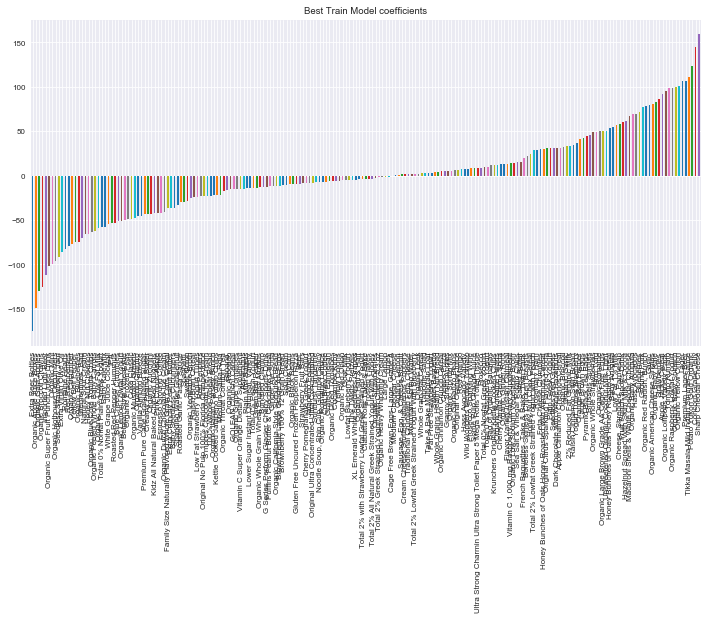

In [29]:
best_prod_model_train_predictors = X_train[best_features_train].columns
best_prod_model_train_coef = pd.Series(best_prod_model_train.coef_,best_prod_model_train_predictors).sort_values()
best_prod_model_train_coef.plot(kind='bar', title="Best Train Model coefficients")

This graph has quite a number of coefficients so very hard to see what is going on, main thing it shows is that the dimenstionality of the problem probably needs to be reduced and also in some runs there are a few clear dominating terms.

### Training R Squared Plot for Varying feature Numbers

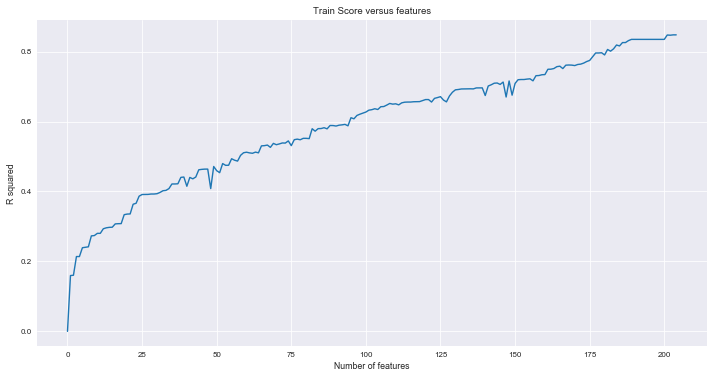

In [30]:
plt.title("Train Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores_train)
plt.show()

It can be seen as the Number of Feature increase, the better training model performs, this makes sense as we are overfitting the data so the more data we can give it when testing against the training data, the closer it will get to 1

### Find best Model, Score by testing

In [31]:
best_features_test, best_score_test, model_scores_test = order_best_features_and_score(X_train, y_train, X_test, y_test, 1)
print("Best Score :", best_score_test, "with", len(best_features_test), "features")

best_prod_model_test = linear_model.LinearRegression(normalize=True)
best_prod_model_test.fit(X_train[best_features_test], y_train)

train_score_with_best = best_prod_model_test.score(X_train[best_features_test], y_train)
print("Score with best model using training data to test :", train_score_with_best)

Best Score : 0.3073352476549729 with 39 features
Score with best model using training data to test : 0.33019659647627975


This is very inverse logic. Find the best scoring model made via the training data with certain features/products with the test data being used to score. From this model, score the training data also and see how it performs. 

As can be seen it performs near equally for both test and train. Overall it produced more accurate results than that of using the training data only to score then testing the test data off the best training model, but the issue now is the test data was used to pick the best model so may now be fitting the test data to the model.

### Coefficients of best Test Model Plot

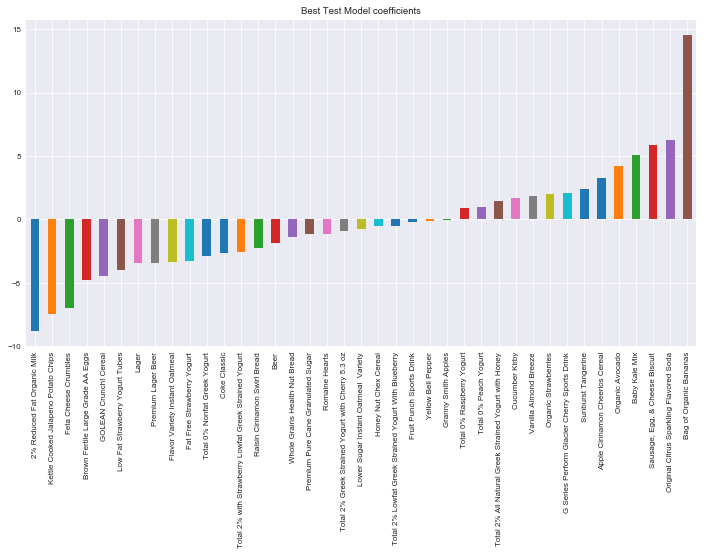

In [32]:
best_prod_model_test_predictors = X_train[best_features_test].columns
best_prod_model_test_coef = pd.Series(best_prod_model_test.coef_,best_prod_model_test_predictors).sort_values()
best_prod_model_test_coef.plot(kind='bar', title="Best Test Model coefficients")

As can be seen there are more negative coefficients than positive coefficients but has many less features than that of the best model obtained by scoring the training data. Also again there are only a few dominating features.

### Testing R Squared Plot for Varying feature Numbers

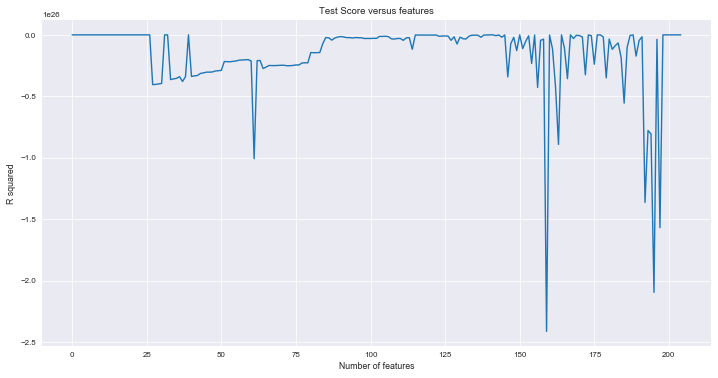

In [33]:
plt.title("Test Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores_test)
plt.show()

As can be seen from the graph,the score is in the factor of 10^26 which is huge so as a result we cannot see when the score is above 0, lets take a smaller sample of them. As the score drops down dramatically (graphy may be different per run), we will pick 20 as the maximum number of score to view.

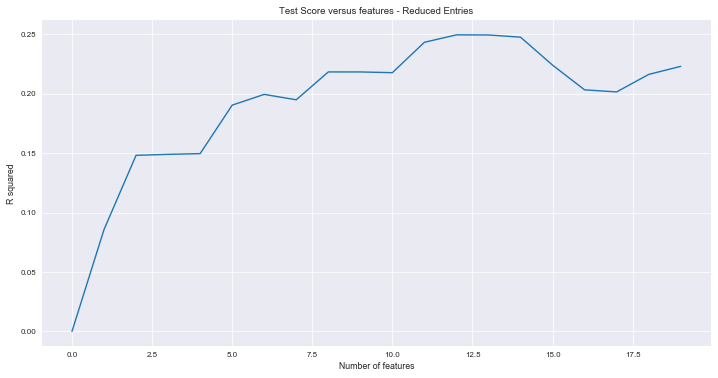

In [34]:
plt.title("Test Score versus features - Reduced Entries")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores_test[:20])
plt.show()

The models appear to perform the best when the have between 11 and 14 features.

An issue we have here is that we are using the testing data to find the best model for it, which means we are overfitting the solution to the test data, ideally we should create a model and ensure it has a good score with its own training data then use the testing data to score that single model

## Product PCA<a class="anchor" id="product-pca"></a>
***

In [35]:
# Fit on training set only.
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
scaler.fit(X_train)


X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

# Make an instance of the Model 
# 0.8 was chosen due to a suck it and see approach as this gave the best scores for the model
variance_prod_pca = 0.8 # 0.8 means keep 80% of the variance
pca = PCA(variance_prod_pca)
pca.fit(X_train_scale)

X_train_pca = pca.transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)

# Normalise is not set due to the sclaer being used 
# See : http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
pca_model = linear_model.LinearRegression()
pca_model.fit(X_train_pca, y_train)
pca_train_score = pca_model.score(X_train_pca, y_train)
pca_test_score = pca_model.score(X_test_pca, y_test)

print("Score with training data :", pca_train_score, ". Score with testing data :", pca_test_score)

Score with training data : 0.4811945507160911 . Score with testing data : 0.16865733442085784


The scores are low here, 0.48 for training and 0.17 for testing (as of writing this). One of the best scores we have seen for far for training with a positive testing score.

## Aisle Rollup<a class="anchor" id="aisle"></a>
***

### Extract Desired Columns

In [36]:
aisle_key_cols = key_columns("aisle_id")
wanted_info_train = train_orders_prod[aisle_key_cols]
wanted_info_test = test_orders_prod[aisle_key_cols]

wanted_info_train.head()

,order_id,days_to_next_order,aisle_id
0,3411808,8.0,83
1,573593,3.0,83
2,3312511,9.0,83
3,27068,0.0,83
4,2989600,14.0,83


### Add the Aisle Columns

In [37]:
df_with_aisle_info_train = add_each_aisle_to_df(wanted_info_train)
df_with_aisle_info_test = add_each_aisle_to_df(wanted_info_test)

df_with_aisle_info_train.head()

,order_id,days_to_next_order,aisle_id,aisle,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,3411808,8.0,83,fresh vegetables,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,573593,3.0,83,fresh vegetables,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3312511,9.0,83,fresh vegetables,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,27068,0.0,83,fresh vegetables,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2989600,14.0,83,fresh vegetables,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Populate the Aisle Columns

In [38]:
# Aggregates the data so we have days to next order with the aisles required checked
cols_to_drop = ["aisle", "aisle_id", "order_id"]
item = "aisle"
df_aisle_group_train = group_by_order_in_df(df_with_aisle_info_train, item, cols_to_drop)
df_aisle_group_test = group_by_order_in_df(df_with_aisle_info_test, item, cols_to_drop)

df_aisle_group_train.head()

,days_to_next_order,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,8.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


### Preparing the data for modelling

In [39]:
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_aisle_group_train, df_aisle_group_test)
# Where X are the features and Y is the days to next order (value trying to predict)
X_train.head()

,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,kitchen supplies,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


### Generate the Model

In [40]:
model = linear_model.LinearRegression(normalize=True)
model.fit(X_train, y_train)
model.intercept_

11.692365679824562

### Score the Model

In [41]:
model.score(X_test, y_test)

-2.446628204719114e+28

### Find the best feature/aisle

In [42]:
find_best_feature(X_train, y_train, X_test, y_test)

(0.08760018310333306, 'fresh vegetables')

### Find best features in Order and calculate scores based on testing data

In [43]:
best_features_test, best_score_test, model_scores_test = order_best_features_and_score(X_train, y_train, X_test, y_test, 1)

best_aisle_model_test = linear_model.LinearRegression(normalize=True)
best_aisle_model_test.fit(X_train[best_features_test], y_train)

train_score_with_best = best_aisle_model_test.score(X_train[best_features_test], y_train)

print("Best Score using test data :", best_score_test, "Score using train data :", train_score_with_best)

Best Score using test data : 0.30823678396719423 Score using train data : 0.3168721757442158


### Aisle Rollup Best Model Coefficients

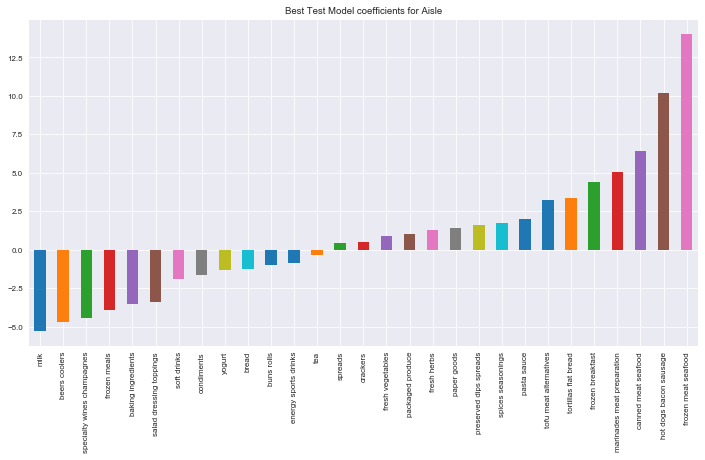

In [44]:
best_aisle_model_test_predictors = X_train[best_features_test].columns
best_aisle_model_test_coef = pd.Series(best_aisle_model_test.coef_,best_aisle_model_test_predictors).sort_values()
best_aisle_model_test_coef.plot(kind='bar', title="Best Test Model coefficients for Aisle")

As always the better model has lower dimensions, it can be seen here that the coefficients are quite well distributed, some bigger than others but no very large factors of dominance.

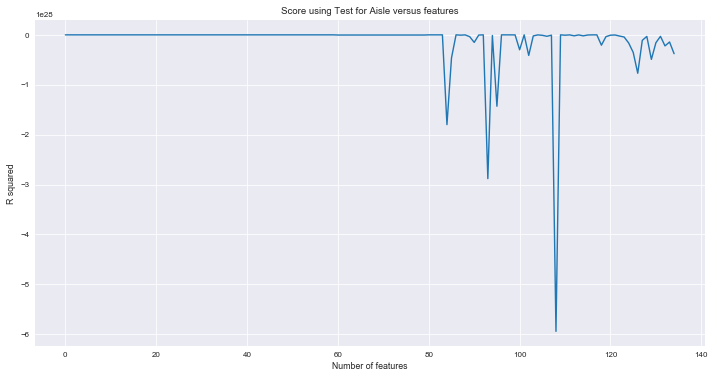

In [45]:
plt.title("Score using Test for Aisle versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores_test)
plt.show()

Same issues as before, using the test data to pick a model based on the best score obtained from the test data. As can be seen from the print out before the graph, the model has not performed as well as a model using the reduced product set or PCA (on average), it is not very far off those models however

## Regularisation - Ridge Regression with Product<a class="anchor" id="ridge"></a>
***

In [46]:
# Very suck it an see approach to try find 
ridge_reg_model_prod = Ridge(alpha=2.5)
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_prod_group_train, df_prod_group_test)

ridge_reg_model_prod.fit(X_train, y_train)
ridge_prod_train_score = ridge_reg_model_prod.score(X_train, y_train)
ridge_prod_test_score = ridge_reg_model_prod.score(X_test, y_test)
print("Ridge Model Score with training :", ridge_prod_train_score, " Score with testing :", ridge_prod_test_score)

Ridge Model Score with training : 0.6570861378451516  Score with testing : 0.18412971970654446


Chosing λ (alpha in this case) is difficult due to if it is too large, it will increase the bias as it matches the data less and if it is too small it matches the data too much and increases variance.

From a training perspective this performed well-ish in that it has a score of 0.63 which is the highest train scored obtained whilst the testing score remaining postivie. The testing score on the other hand is 0.18 which is fairly consistent throughout most models which have been created

## Regularisation - Lasso Regression with Product<a class="anchor" id="lasso"></a>
***

In [47]:
lasso_alpha = 0.07
lasso_reg_model_prod = Lasso(alpha=lasso_alpha)
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_prod_group_train, df_prod_group_test)
lasso_reg_model_prod.fit(X_train, y_train)

lasso_prod_train_score = lasso_reg_model_prod.score(X_train, y_train)
lasso_prod_test_score = lasso_reg_model_prod.score(X_test, y_test)
print("Lasso Model Score with training :", lasso_prod_train_score, " Score with testing :", lasso_prod_test_score)

Lasso Model Score with training : 0.4839718867542868  Score with testing : 0.16372575668022327


Similar issue picking lamba here, it was found based on a trial and error approach (considering the calculation time it takes doing all the products and finding the best model I didn't want the notebook taking much longer).

As can be seen, the lasso here did not perform as well as Ridge given the training score and testing score are both less than Ridge. The testing score is not too far off that of Ridge and overall, so far no good model has been created that has a high (over 0.5) score of both training and test. 

Lasso performed very similar to PCA scoring wise.

## Comparison Before User Investigation <a class="anchor" id="compbu"></a>
***

Although not many forms of dimensionality reduction were investigated (didn't look into correlating variables mainly due to laziness and that the 'brute force' way of comparing models would give a small dimension that using all products) I believe it is safe to say that the smaller the dimesion models performed better.

Since there are so many products, it took too long to even generate the matrix of 1s and 0s of products for an order so that had to be reduced straight away. Initially it was thought that to only use products that actually appeared in my slice of the data but even that was quite large so I thought it best to go with products that were ordered 3 times or more as this gave a more "manageable" (depending on hardware) feature matrix. From this a brute force approach was ran to try and find the best model (reducing the number of product features on each run and storing the best results) either scoring by the training data or test data. It was clear if this approach was taken for scoring by training that a terrible model is obtain, around a 0.8 score but when it came to testing it was a terrible score (negative due to the implementation), this model has mostly all the features. From using a testing scorer the best model worked out to be about 0.3 or 0.4 for both the training and test score, this had many fewer features than that of the train scored one. 
Would I recommend this approach again? No I'd correlate the features and reduce that way rather than the Brute force approach for finding the best model as this would save a lot more on compute power (this notebook isn't very lower end hardware friendly). However the Brute Force way did show the extreme drop off in performance (even though most of the models are terrible anyway, in most cases predicting just on the 2% organic milk would give you about the same success score) when too many features are used, from the testing data perspective.

The aisle roll up was investigated from the Brute Force approach performed very similar (around 0.3 for test and train) to the Brute Force product approach when scoring by test data. This makes sense as the products probably belonged to the aisle it was rolled up in to and as the aisles were scored by test it would make sense the values are similar.

From PCA, Ridge and Lasso as regards dimension reduction, Ridge performed the best from a training point of view (usually has a train score of 0.6 and test of 0.2). PCA performed similar to obtaining a model using the Brute Force (around 0.4 for train and 0.2 test score). Lasso performed the worst from a testing score and middle for the training score. Overall, as the the aim of the model is to predict the test data, Ridge wins. However the numbers picked for variance in PCA and lambda in Lasso and Ridge were trial and error so it is possible that I did not find a good value from manualy testing. What can be drawn from these investigation is that reducing the dimensionality did improve the model as using all the products (even just popular ones) is far too contrained of a model.

As Aisle rollup using test scoring appear to perform the most symmetrical between test and train score I will use that for the individual user investigation.

## Specific User Investigation<a class="anchor" id="user"></a>

In [48]:
# For the User
# Usual Setup, did'nt want to break it into loads of stages as before, just get to the meat
aisle_key_cols = key_columns("aisle_id")
train_orders_prod, test_orders_prod = join_products(user_train_orders, user_test_orders)
wanted_info_train = train_orders_prod[aisle_key_cols]
wanted_info_test = test_orders_prod[aisle_key_cols]
df_with_aisle_info_train = add_each_aisle_to_df(wanted_info_train)
df_with_aisle_info_test = add_each_aisle_to_df(wanted_info_test)
cols_to_drop = ["aisle", "aisle_id", "order_id"]
item = "aisle"
df_aisle_group_train = group_by_order_in_df(df_with_aisle_info_train, item, cols_to_drop)
df_aisle_group_test = group_by_order_in_df(df_with_aisle_info_test, item, cols_to_drop)
df_aisle_group_train.head()

,days_to_next_order,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Generate the Model

In [49]:
X_train, y_train, X_test, y_test = split_data_to_features_and_value(df_aisle_group_train, df_aisle_group_test)
best_features, best_score, model_scores = order_best_features_and_score(X_train, y_train, X_test, y_test, 1)

best_aisle_model_user_test = linear_model.LinearRegression(normalize=True)
best_aisle_model_user_test.fit(X_train[best_features], y_train)

train_score_aisle_user_with_best = best_aisle_model_user_test.score(X_train[best_features], y_train)

print("Best Score using test data :", best_score, "Score using train data :", train_score_aisle_user_with_best)

Best Score using test data : 0.451621277189612 Score using train data : 0.08400252283334175


Best performer as regard testing data however the training score is awful so the model now possibly overfits the testing data.

### Find Best Feature

In [50]:
find_best_feature(X_train, y_train, X_test, y_test)

(0.16665789252021568, 'packaged vegetables fruits')

Surprising, its not milk

### Best User Aisle Model Coefficients

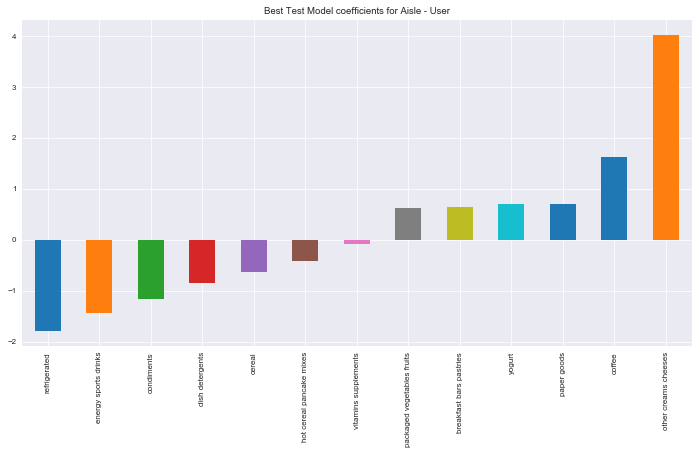

In [51]:
best_aisle_model_user_test_predictors = X_train[best_features].columns
best_aisle_model_user_test_coef = pd.Series(best_aisle_model_user_test.coef_,best_aisle_model_user_test_predictors).sort_values()
best_aisle_model_user_test_coef.plot(kind='bar', title="Best Test Model coefficients for Aisle - User")

Overall distribution does not look too biased to one feature though there is still one larger one (other cream cheese)

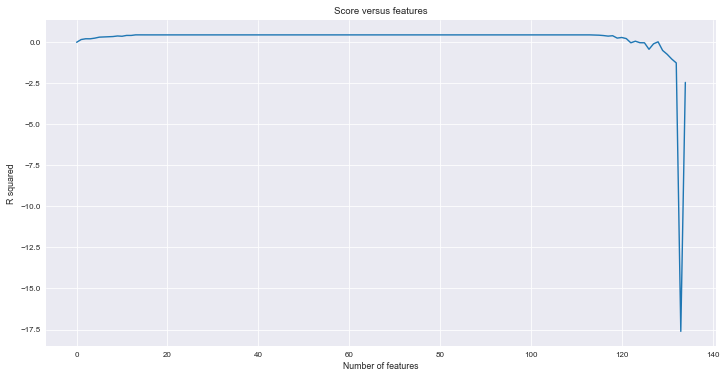

In [52]:
plt.title("Score versus features")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores)
plt.show()

Again as the features increase past a certain point, model becomse worse

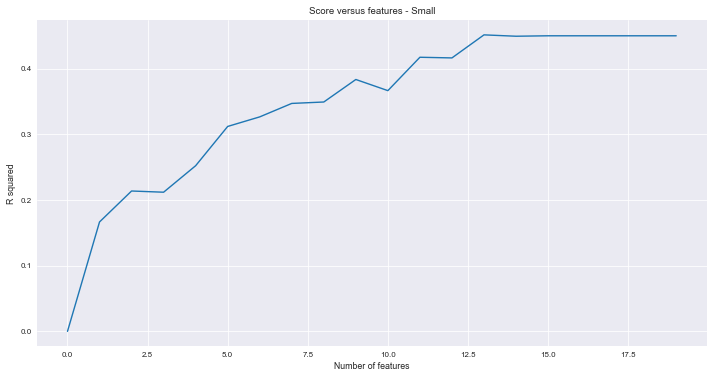

In [53]:
plt.title("Score versus features - Small")
plt.xlabel('Number of features') 
plt.ylabel('R squared')
plt.plot(model_scores[:20])
plt.show()

As can be seen if we zoom in on the graph, after about 13 features, the testing performance is at a maximum

## Comparison After User Investigation <a class="anchor" id="compau"></a>
***

Overall, the user investigation is much the same as the product/aisle investigation. Too many features/data lead to too much variance and a bad model, not enough features would lead to too much bias and not a very good model also.

The User created model did predict the best for that user with over 0.45 score for the testing data, but the training data score was so low (less than 0.1) that the model is probably not of much use. One would expect that it is easier to predict the order of a specific user given that user's pervious orders than if you were to predict the next order (of anyone) based on all previous orders (from everyone).

The main draw from this investigation is that products/aisles (and departments by extension) alone are probably not enough information to predict a next order, other data like how often the user buys items, what day is their usual grocery shop, what is their most bought product (and I'm sure many others) would be needed to more accurately generate a model. Of course, dimensionality must also be watched when doing this.